In [1]:
merging_datasets <- c("SCIA", "ISAC")
state <- "Valle D'Aosta"
match_dist <- 15000
new_dataset <- "VDA"

In [2]:
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))
library(arrow, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)

source("src/database/tools.R")
source("src/database/insert.R")
source("src/database/write.R")
source("src/database/startup.R")
source("src/database/plot.R")
source("src/database/query/spatial.R")
source("src/database/query/data.R")
source("src/merging/analysis.R")
source("src/merging/display.R")
source("src/merging/combining.R")
source("src/merging/tagging.R")
source("notebooks/integrazioni_regionali/procedure/common_steps.R")

conns <- load_dbs()
state_boundaries <- query_boundary(conns$stations, "Valle D''Aosta", "state")


Linking to GEOS 3.11.0, GDAL 3.5.3, PROJ 9.1.0; sf_use_s2() is TRUE



In [3]:
metadata <- query_checkpoint_meta(merging_datasets, "qc1", conns$data) |>
    collect() |>
    st_md_to_sf() |>
    st_filter(state_boundaries |> st_buffer(dist = 100), .predicate = st_within) |>
    st_drop_geometry() |>
    filter(!(state %in% c("Piemonte")), !(network %in% c("Sinottica", "Mareografica"))) |>
    arrange(dataset, sensor_key) |>
    mutate(key = row_number())
metadata_db <- copy_to(conns$data, metadata, "metas_tmp", overwrite = TRUE)

sensor_matches <- close_matches(metadata_db, match_dist, conns$stations)

data <- query_checkpoint_data(merging_datasets, "qc1", conns$data) |>
    filter(valid) |>
    inner_join(metadata_db |> select(dataset, sensor_key, key), by = c("dataset", "sensor_key")) |>
    select(!c(starts_with("qc_"), valid)) |>
    compute()

var_matches <- series_matches(data, sensor_matches, metadata_db)


In [9]:
analysis <- series_matches_analysis(var_matches, data, metadata_db, matches_offsets = c(-1L, 0L, 1L))
analysis |> write_xlsx_analysis(file.path("notebooks", "integrazioni_regionali", "vda", "raw_analysis.xlsx"))


In [10]:
source("notebooks/integrazioni_regionali/vda/procedures/match_taggers.R")
tagged_analysis <- analysis |>
    tag_same_series() |>
    default_logic(require_all = TRUE) |>
    tag_manual()

write_xlsx_analysis(tagged_analysis, file.path("notebooks", "integrazioni_regionali", "vda", "tagged_analysis.xlsx"), starts_with("tag_"))


In [15]:
gs <- series_groups(tagged_analysis, metadata, data, tag_same_series)
ranked_series_groups <- rank_series_groups(gs$table, metadata, merging_datasets, desc(dataset), desc(sensor_last))
incomp <- incompatible_merges(data, ranked_series_groups, tagged_analysis, 12L, 0.5)


In [16]:
i <- incomp |>
    left_join(metadata |> select(key, name, dataset, sensor_key), by = c("key_x" = "key")) |>
    left_join(metadata |> select(key, name, dataset, sensor_key), by = c("key_y" = "key")) |>
    arrange(desc(abs(k0)))
i

pkey,k0,k1,k2,k3,gkey,key_x,key_y,variable,offset_days,name.x,dataset.x,sensor_key.x,name.y,dataset.y,sensor_key.y
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<int>
2,-1.4326029,0.24942943,0.02914428,0.0422806372,43,142,68,1,-1,Pr<U+00EF><U+00BF><U+00BD>-Saint-Didier - Capoluogo Valle,SCIA,2494,PRE_SAINT_DIDIER_CAPOLUOGO,ISAC,3921
10,-1.3645575,-0.07966606,0.09808861,0.0010849292,22,115,65,1,0,Gressoney-La-Trinit<U+00EF><U+00BF><U+00BD> - Alpe Courtlys,SCIA,1350,GRESSONEY_LA_TRINITE_ALPE_COURTLYS,ISAC,3918
2,-1.1330271,-0.19594104,-0.12912393,0.0013531182,43,142,45,1,1,Pr<U+00EF><U+00BF><U+00BD>-Saint-Didier - Capoluogo Valle,SCIA,2494,PRE_SAINT_DIDIER,ISAC,2560
86,-1.0338949,-0.19570601,-0.13091447,0.0488854045,43,142,141,1,1,Pr<U+00EF><U+00BF><U+00BD>-Saint-Didier - Capoluogo Valle,SCIA,2494,Pr<U+00EF><U+00BF><U+00BD>-Saint-Didier - Capoluogo,SCIA,2493
85,-0.9599572,-0.03389462,-0.05155033,-0.0047977165,43,142,141,-1,-1,Pr<U+00EF><U+00BF><U+00BD>-Saint-Didier - Capoluogo Valle,SCIA,2494,Pr<U+00EF><U+00BF><U+00BD>-Saint-Didier - Capoluogo,SCIA,2493
1,-0.8997021,-0.06004440,-0.06478395,-0.0006613401,43,142,45,-1,-1,Pr<U+00EF><U+00BF><U+00BD>-Saint-Didier - Capoluogo Valle,SCIA,2494,PRE_SAINT_DIDIER,ISAC,2560
1,-0.7981751,-0.06070526,-0.05928449,0.0083375491,43,142,68,-1,-1,Pr<U+00EF><U+00BF><U+00BD>-Saint-Didier - Capoluogo Valle,SCIA,2494,PRE_SAINT_DIDIER_CAPOLUOGO,ISAC,3921
12,-0.7161938,0.13339615,-0.13582075,0.0170217890,23,117,66,1,0,Gressoney-La-Trinit<U+00EF><U+00BF><U+00BD> - Gabiet,SCIA,1352,GRESSONEY_LA_TRINITE_GABIET,ISAC,3919
2,0.6172070,0.01967743,0.18571095,0.1109601181,2,83,3,1,1,Ayas - Alpe Courthoud,SCIA,197,AYAS_ALPE_COURTHOUD,ISAC,227


In [17]:
merge_results <- dynamic_merge(data, ranked_series_groups, metadata, tagged_analysis, 10)
db <- merged_checkpoint(merge_results, metadata, new_dataset)
rm(merge_results)
gc()

,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2143908,114.5,3862104,206.3,NA,3862104,206.3
Vcells,12650215,96.6,50554601,385.8,16384,65692158,501.2


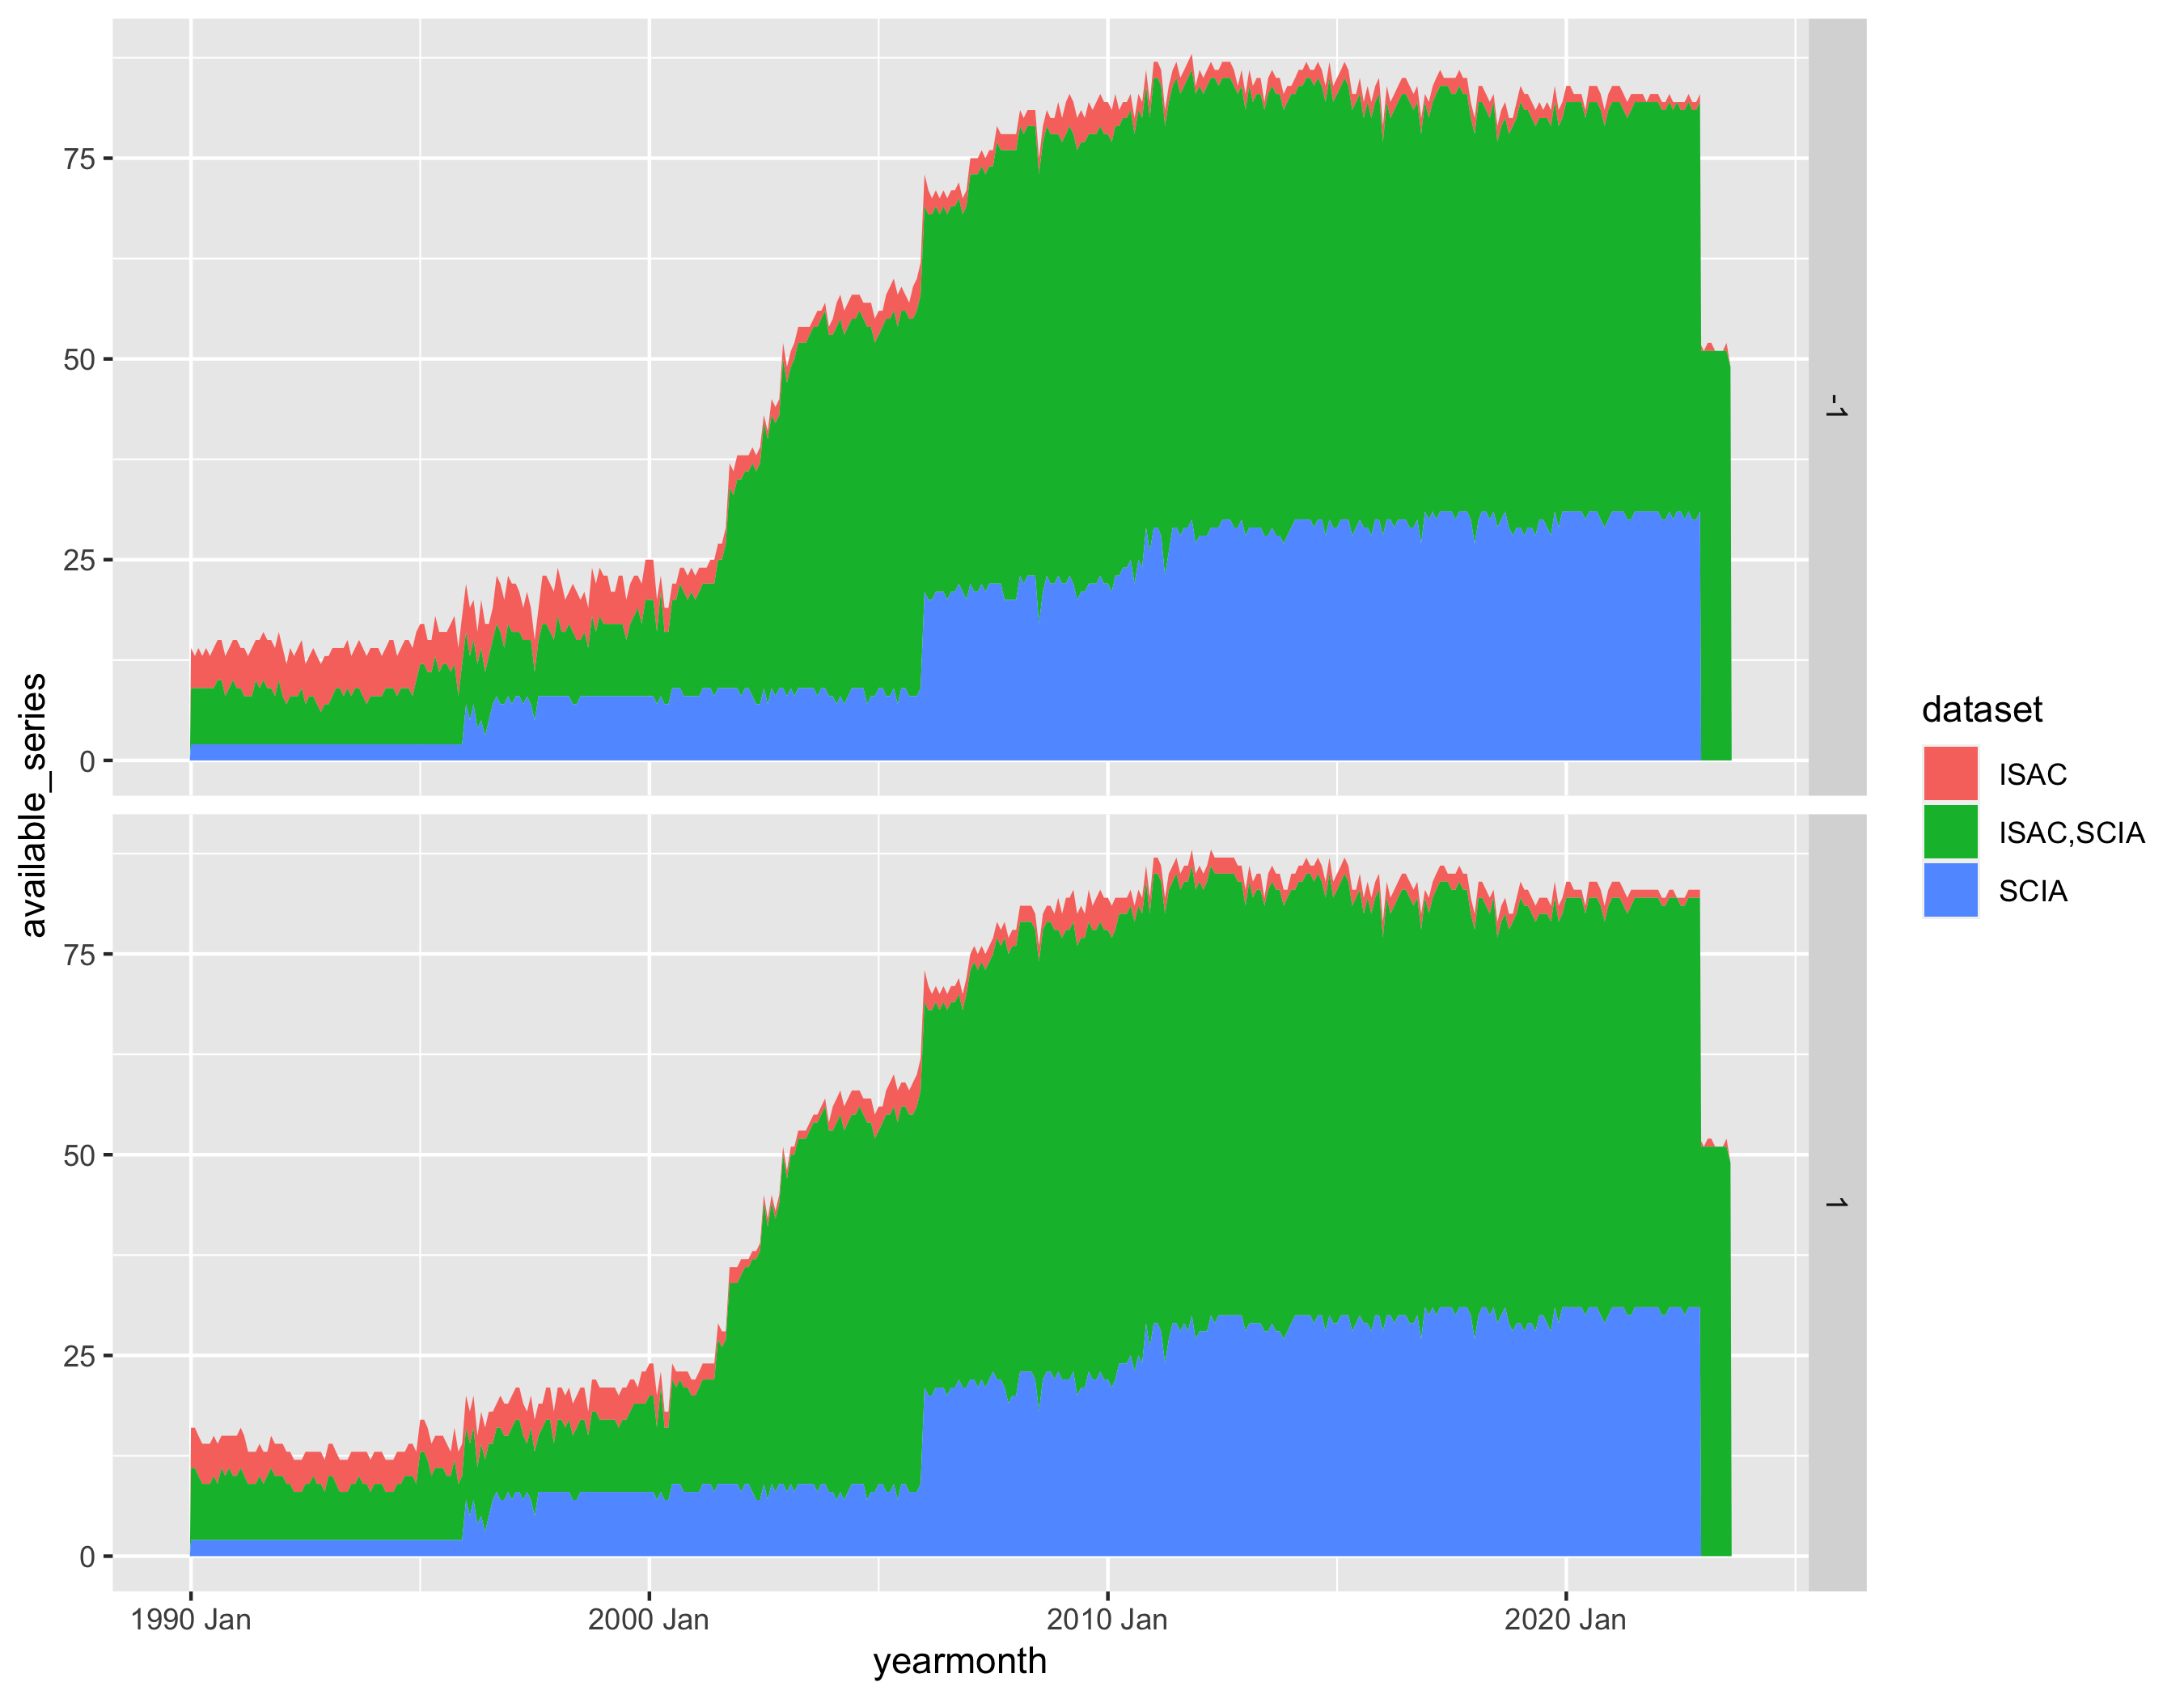

In [21]:
db <- query_checkpoint(new_dataset, "merged", conns$data, all_stations = FALSE)
mt <- db$meta |> select(sensor_key, from_datasets) |> collect() |> rowwise() |> mutate(dataset = paste0(from_datasets |> unique() |> sort(), collapse = ",")) |> ungroup() |> select(-from_datasets)
dt <- db$data |> select(-dataset) |> left_join(mt, by = "sensor_key", copy = TRUE) |> filter(year(date) >= 1990L)
pd <- ymonthly_availabilities(dt, stack = TRUE)
pd$plot + facet_grid(variable ~ .)

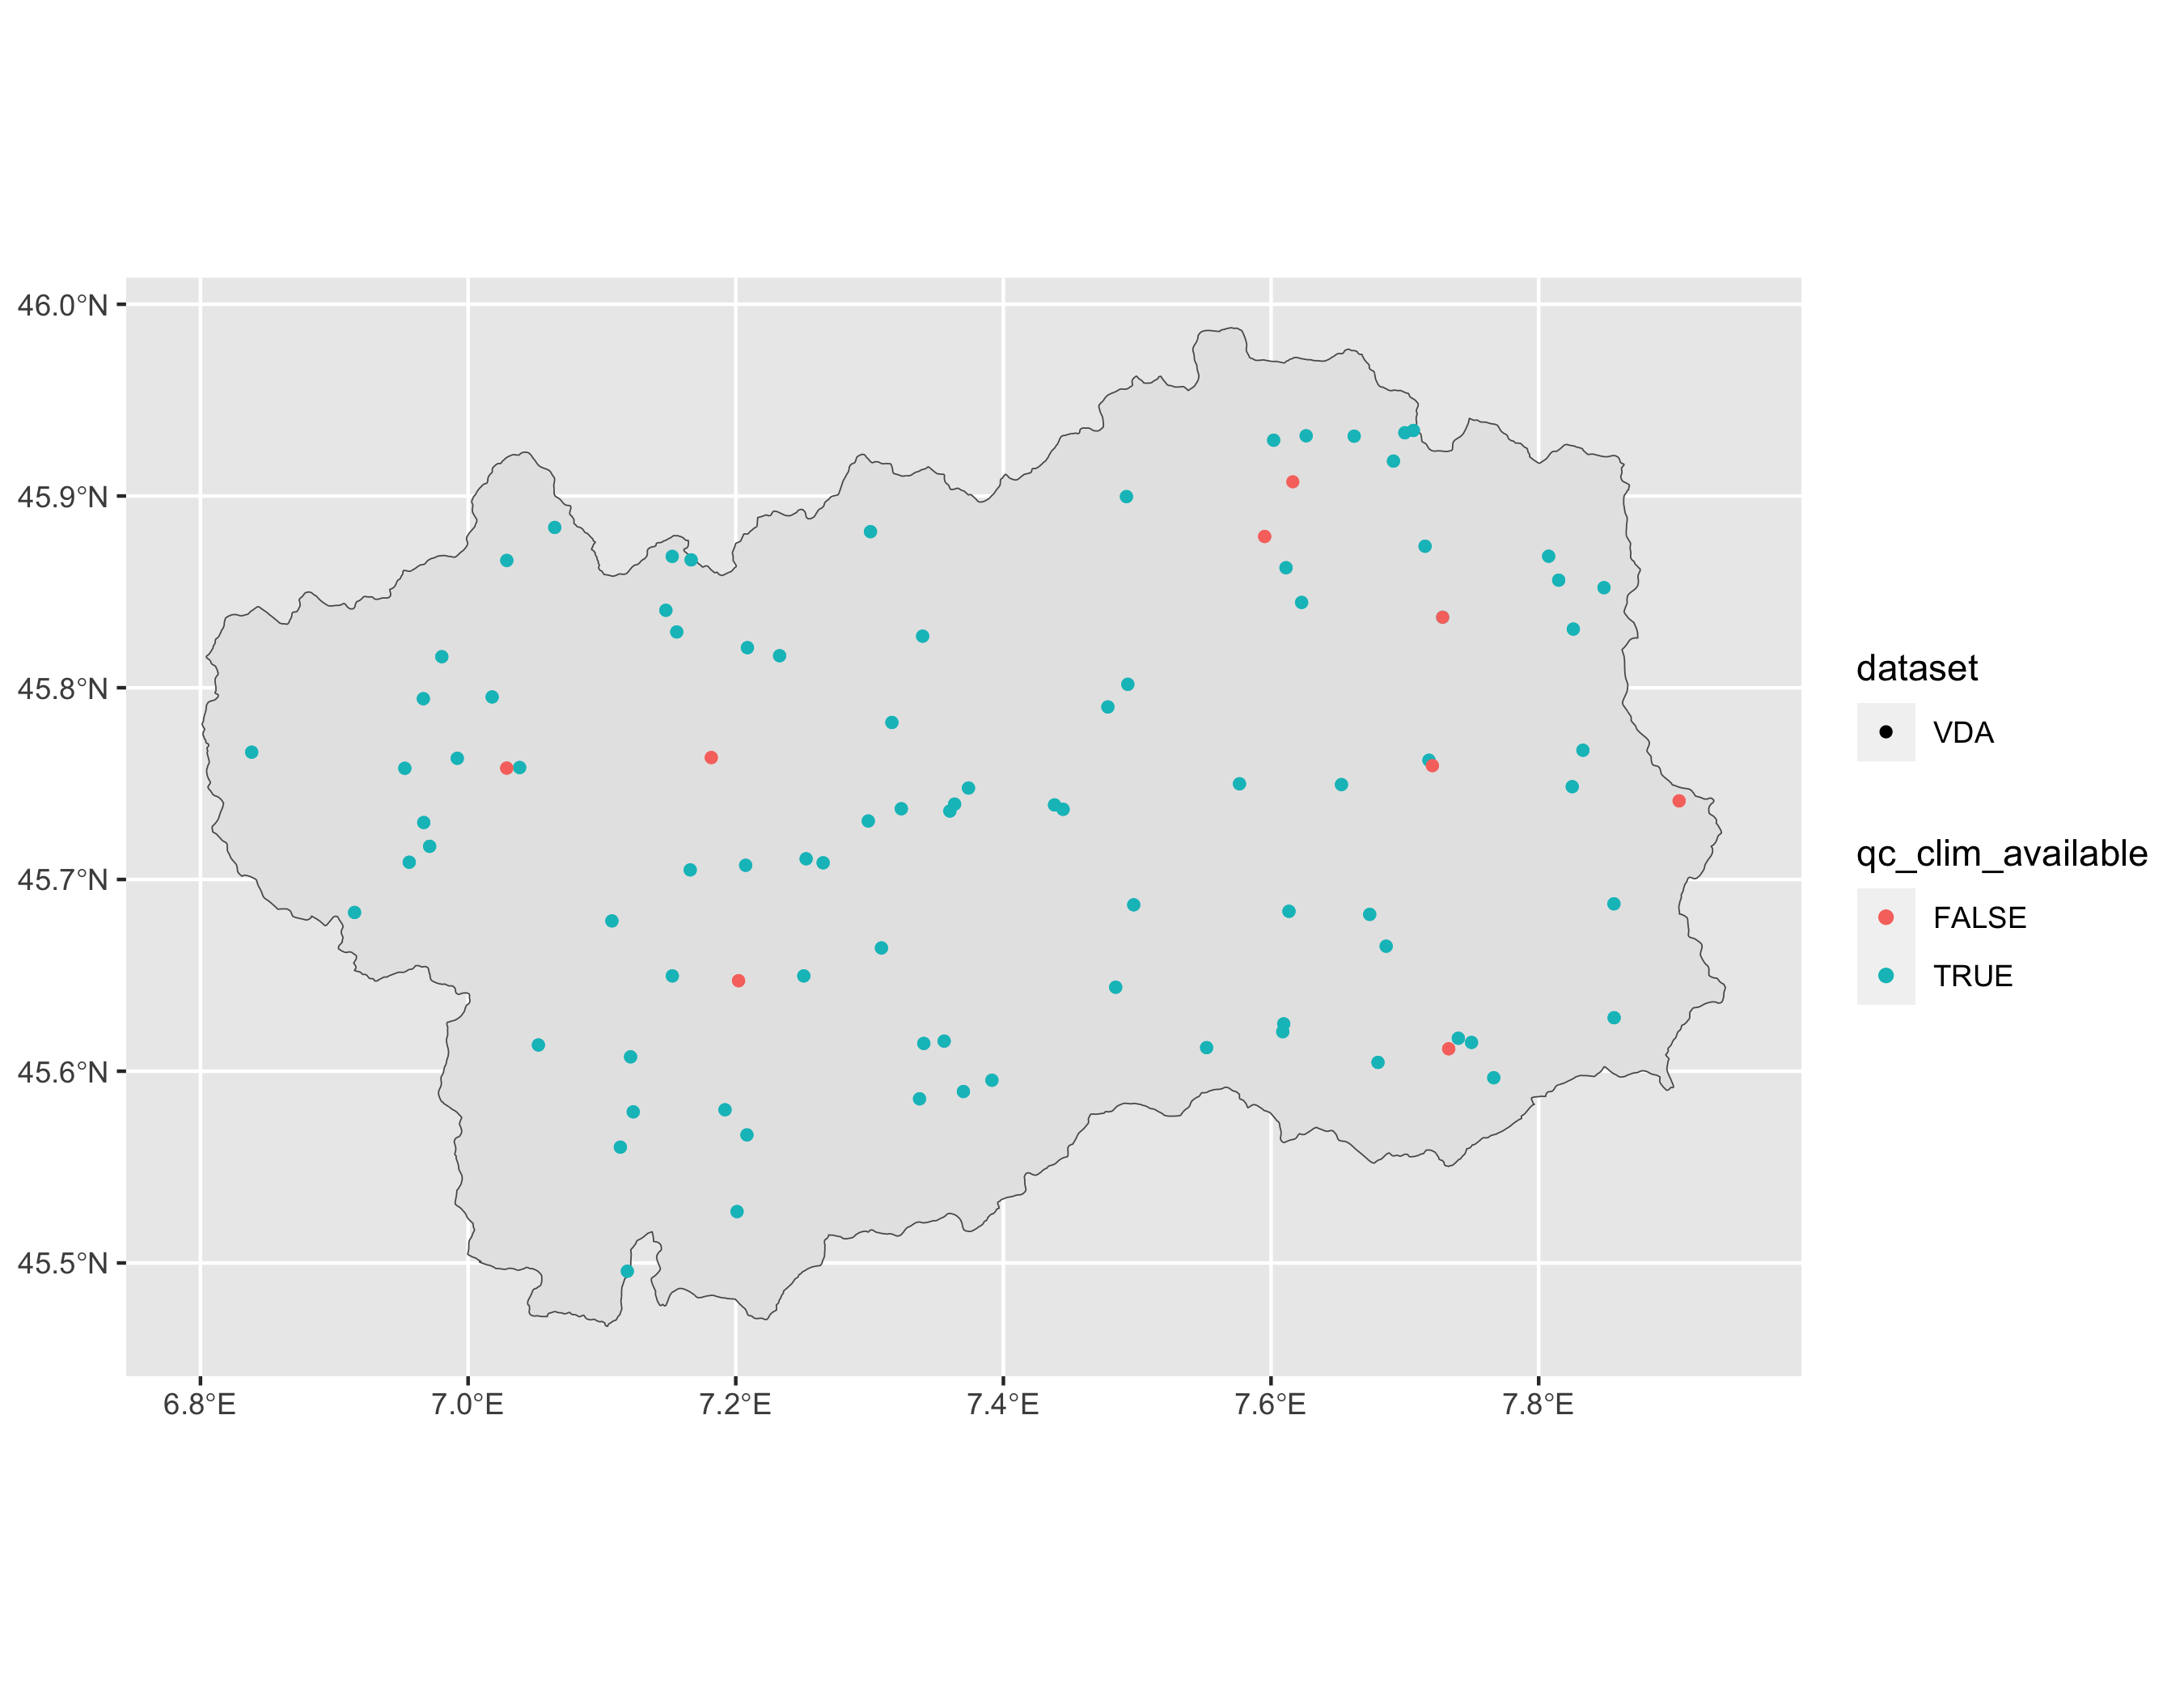

In [22]:
pd <- spatial_availabilities(pd$data |> mutate(dataset = new_dataset), db$meta, state_boundaries)
pd$plot 

Warning message:
"Removed 28 rows containing non-finite values (`stat_bin()`)."


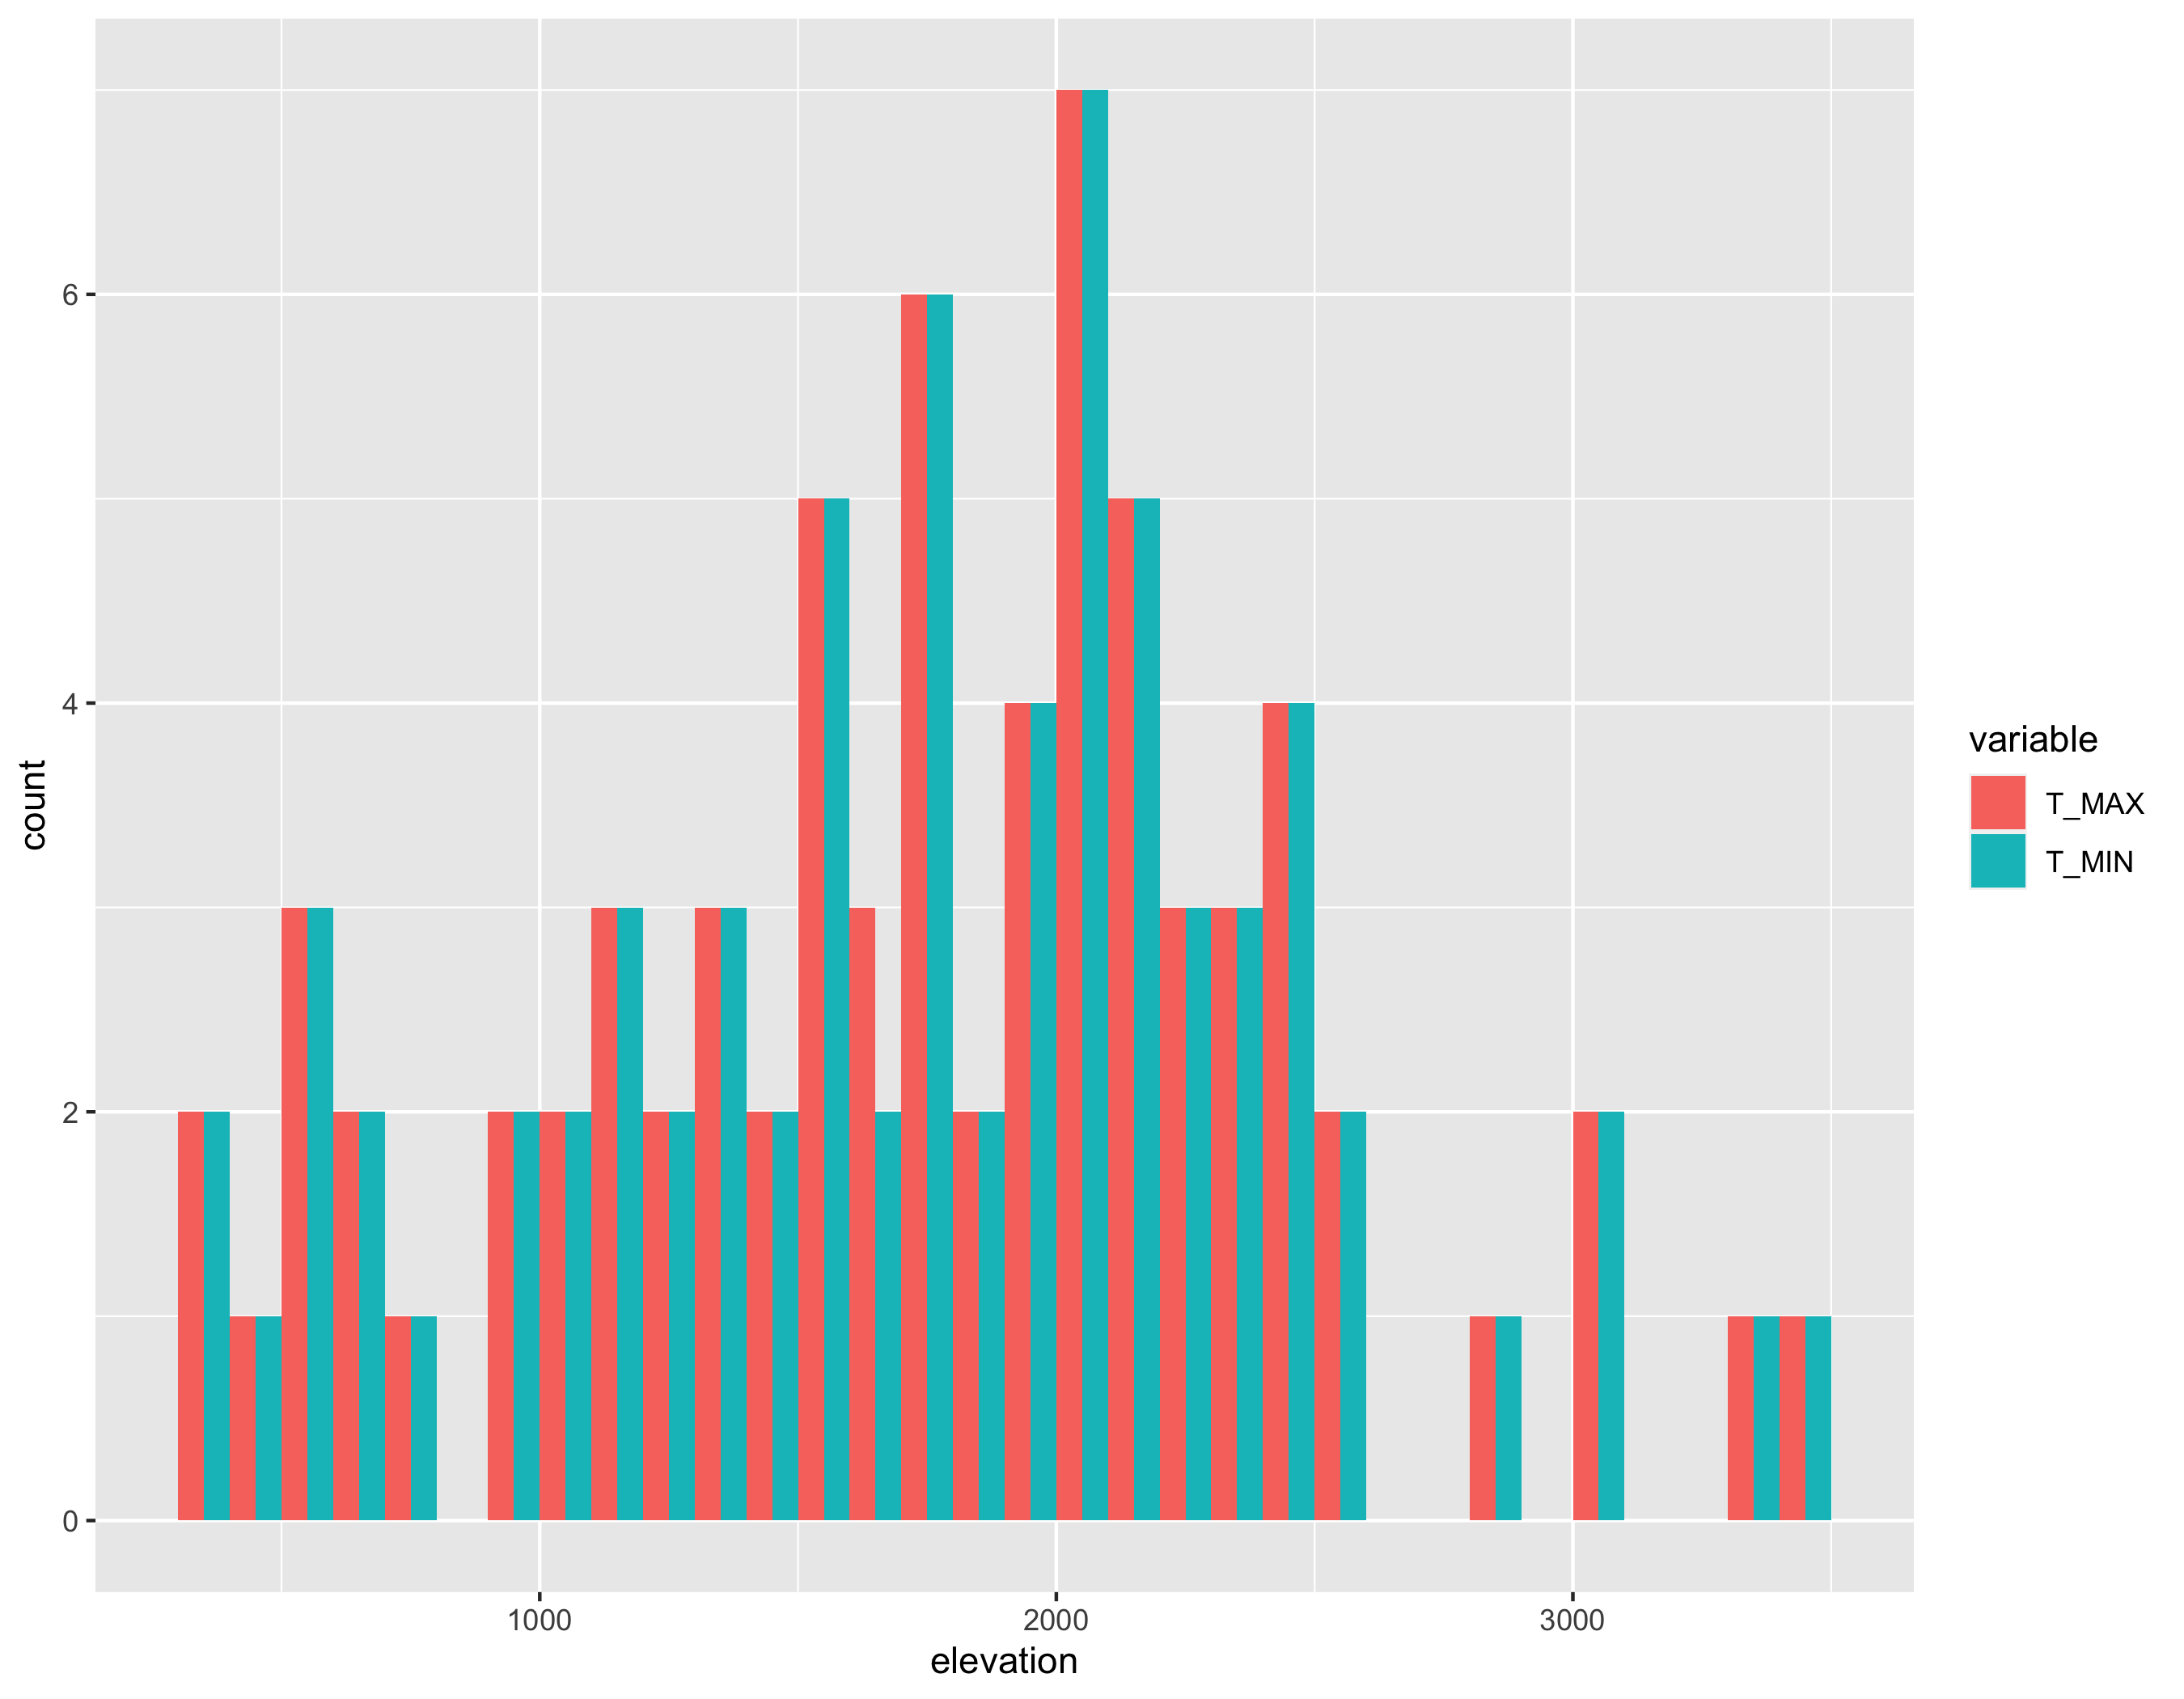

In [23]:
clim_availabilities <- pd$data |> mutate(dataset = new_dataset)
plot_available_by_elevation(clim_availabilities, db$meta |> collect())